In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'

import sys
sys.path.append("../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import scipy

import networkx as nx

In [3]:
sc.settings.set_figure_params(dpi_save=1200, vector_friendly=True, fontsize=18)
plt.rcParams['axes.grid'] = False
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [4]:
from decipher_model import DecipherConfig, Decipher
from load_data import palette_original
from post_analysis import rotate_decipher_space, cluster_representations, compute_trajectories, compute_decipher_time
from post_analysis_plotting import plot_decipher_v, plot_trajectory, plot_gene_patterns, add_cell_type_band

## Load trained model

In [18]:
patient_name = "AML1"

In [5]:
adata = sc.read_h5ad(f"data/{patient_name}.decipher.h5ad")
n_genes = adata.shape[1]

cvi_config = DecipherConfig(
    seed=0,
    learning_rate=1e-3,
)
model = Decipher(
    genes_dim=n_genes,
    decipher_config=cvi_config,
)
model.load_state_dict(torch.load(f"data/{patient_name}.decipher.pth"))
model.eval();


# compatibility - to do in original adata
adata.obsm["decipher_v"] = adata.obsm["latent_p"]
adata.obsm["decipher_z"] = adata.obsm["latent_z"]
adata.obs["origin"] = adata.obs["origin"].replace({"p89":patient_name, "healthy": "Healthy"})

V4


In [6]:
adata.obs["origin_int"] = adata.obs["origin"].replace({patient_name: 1, "Healthy": 0})
rotate_decipher_space(
    adata, "origin_int", decipher_component_to_align_label_with=2, flip_latent_z=True
)

/opt/miniconda3/envs/latent-manifold/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'origin' as categorical
/opt/miniconda3/envs/latent-manifold/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


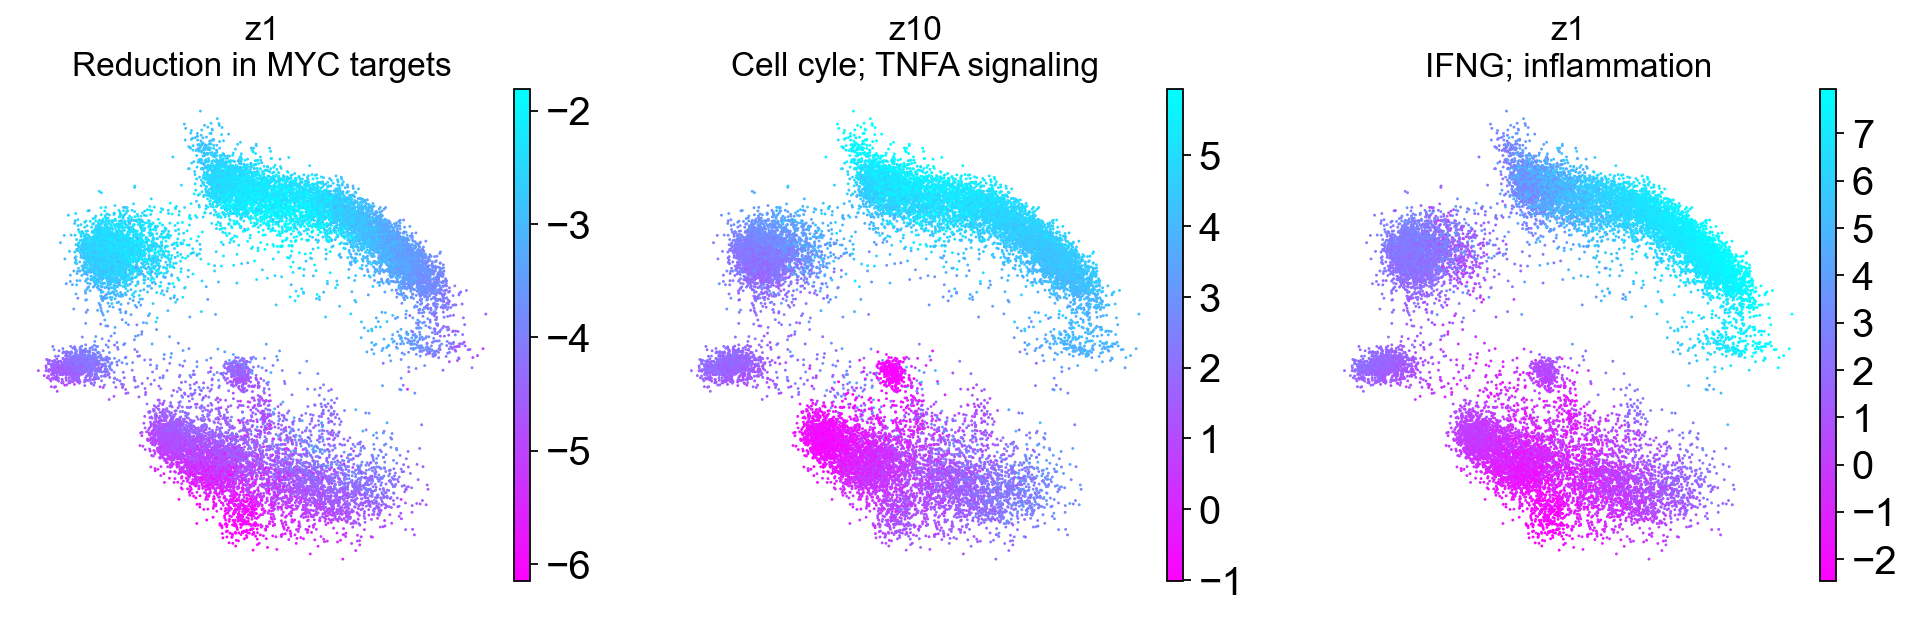

In [7]:
with plt.rc_context({'axes.titlesize':15 , 'axes.labelsize':0, 'figure.figsize': [4,4]}):
    for i in range(10):
        adata.obs["z%d" % (i+1)] = adata.obsm["decipher_z_corrected"][:,i]
    fig = sc.pl.embedding(
        adata,
        basis="decipher_v_corrected",
        color=["z%d" % (i) for i in [1,10,2]],
        vmax=lambda xs: np.quantile(xs, 0.99),
        vmin=lambda xs: np.quantile(xs, 0.01),
        color_map="cool_r",
        frameon=False,
        show=False,
        sort_order=False,
        return_fig=True,
    )
    fig.axes[0].collections[-1].colorbar.set_ticks(range(-10,10))
    fig.axes[2].collections[-1].colorbar.set_ticks(range(-10,10))
    fig.axes[4].collections[-1].colorbar.set_ticks(range(-10,10))
    
    fig.axes[0].set_title("z1\nReduction in MYC targets")
    fig.axes[2].set_title("z10\nCell cyle; TNFA signaling")
    fig.axes[4].set_title("z1\nIFNG; inflammation")
    plt.tight_layout()

plt.savefig(f"figures/figure2/{patient_name}.decipher_space.z_components.pdf", bbox_inches="tight")


In [8]:
cluster_representations(adata)
normal_trajectory = compute_trajectories(
    adata,
    "AVP",
    "MPO",
    subset_column="origin",
    subset_value="Healthy",
    cell_types_key="cell_type_merged",
)
perturbed_trajectory = compute_trajectories(
    adata,
    "AVP",
    "CD68",
    subset_column="origin",
    subset_value=patient_name,
    cell_types_key="cell_type_merged",
)

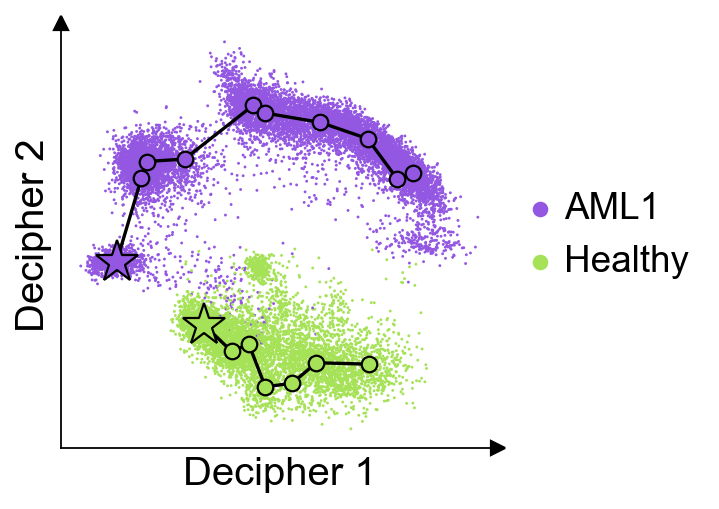

In [19]:
fig = plot_decipher_v(adata, "origin", palette=palette_original)
plot_trajectory(
    adata,
    "origin=Healthy",
    palette_original["Healthy"],
    fig.axes[0],
)

plot_trajectory(
    adata,
    f"origin={patient_name}",
    palette_original[patient_name],
    fig.axes[0],
)
# fig.savefig(f"figures/figure1/{patient_name}.decipher_space.origin.pdf", bbox_inches="tight")
# fig.savefig(f"figures/figure2/{patient_name}.decipher_space.origin.pdf", bbox_inches="tight")

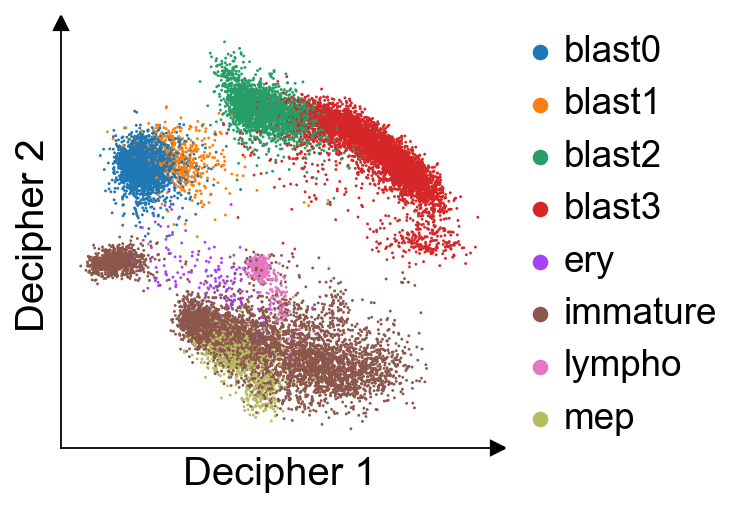

In [10]:
fig = plot_decipher_v(adata, "cell_type_merged")
# fig.savefig(f"figures/figure1/{patient_name}.decipher_space.cell_type.pdf", bbox_inches='tight')
# fig.savefig(f"figures/figure2/{patient_name}.decipher_space.cell_type.pdf", bbox_inches='tight')


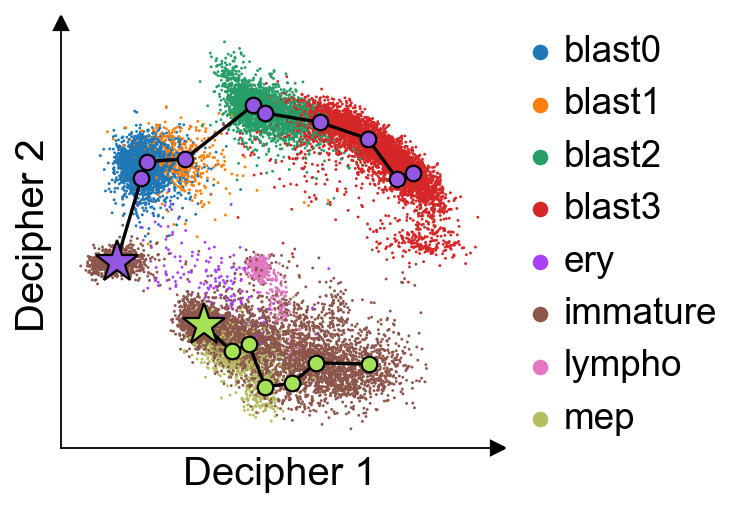

In [11]:
fig = plot_decipher_v(adata, "cell_type_merged")
plot_trajectory(
    adata,
    "origin=Healthy",
    palette_original["Healthy"],
    fig.axes[0],
)

plot_trajectory(
    adata,
    f"origin={patient_name}",
    palette_original[patient_name],
    fig.axes[0],
)
# fig.savefig(f"figures/figure3/{patient_name}.decipher_space.cell_type.with_trajectories.pdf", bbox_inches='tight')


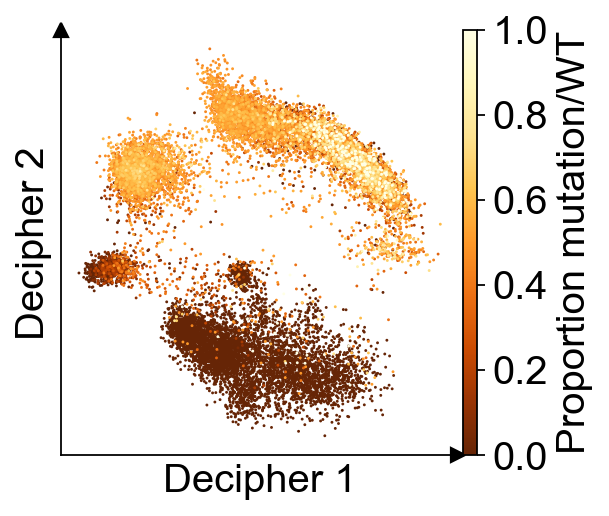

In [12]:
fig = plot_decipher_v(adata, "NPM1 mutation vs wild type", cmap=sns.color_palette("YlOrBr_r", as_cmap=True, ))
fig.axes[0].collections[-1].colorbar.set_label("Proportion mutation/WT")
# fig.savefig(f"figures/figure2/{patient_name}.decipher_space.mutation.pdf", bbox_inches='tight')

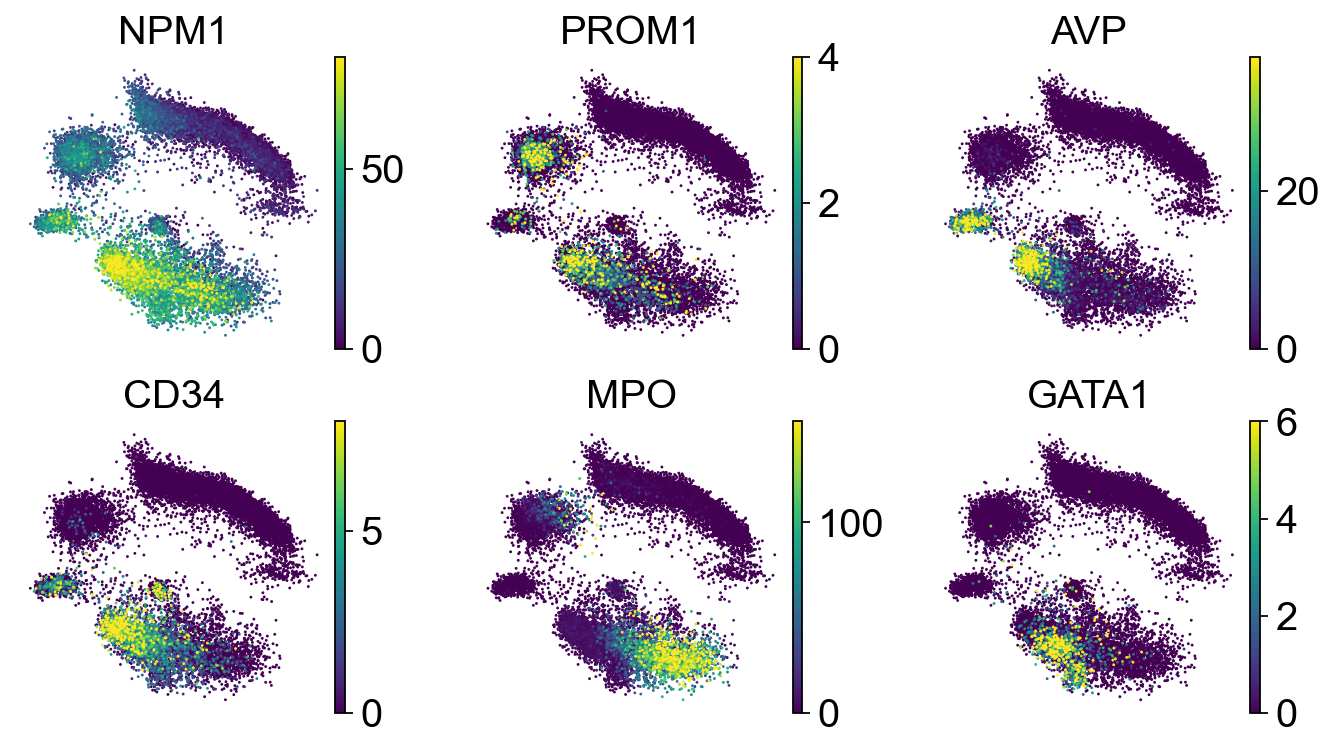

In [13]:
fig = plot_decipher_v(
    adata,
    ["NPM1", "PROM1", "AVP", "CD34", "MPO", "GATA1"],
    show_axis="no",
    ncols=3,
    vmax=lambda x: np.quantile(x, 0.99),
    figsize=(2.5, 2.5),
)
# fig.savefig(f"figures/figure2/{patient_name}.decipher_space.gene_expression.pdf", bbox_inches='tight')

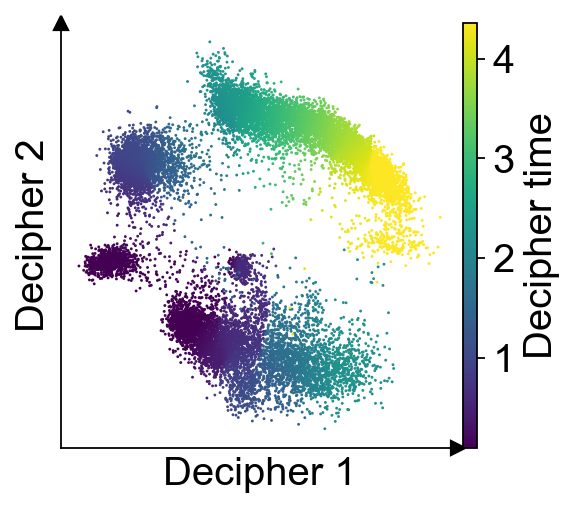

In [53]:
compute_decipher_time(
    adata, {"Healthy": normal_trajectory, patient_name: perturbed_trajectory}
)

fig = plot_decipher_v(adata, "decipher_time")
fig.axes[0].collections[-1].colorbar.set_label("Decipher time")
fig.axes[0].collections[-1].colorbar.set_ticks([0,1,2,3,4])
fig.savefig(f"figures/figure3/{patient_name}.decipher_space.decipher_time.pdf", bbox_inches='tight')

In [15]:
from post_analysis import gene_patterns_from_decipher_trajectory

gene_patterns_from_decipher_trajectory(adata, model)

# we now compare patterns only on their overlapping portions
reference_times = None
min_length = 1_000_000
gene_patterns = []
keys = []
for key in adata.uns["decipher_gene_patterns"]:
    keys.append(key)
    patterns_df = adata.uns["decipher_gene_patterns"][key].T
    if patterns_df.shape[1] < min_length:
        reference_times = patterns_df.columns.values
        min_length = patterns_df.shape[1]
    gene_patterns.append(patterns_df.values)

gene_patterns = np.stack([gg[:, :min_length] for gg in gene_patterns])
adata.uns["decipher_gene_patterns_cropped"] = {
    "patterns": gene_patterns,
    "times": reference_times,
    "keys": keys,
}
# torch.save(
#     {
#         "gene_patterns": gene_patterns,
#         "times": reference_trajectory.trajectory_time,
#     },
#     "AML1.gene_patterns.pt",
# )
# # adata.uns["decipher_gene_patterns_cropped"] =

In [16]:
from basis_decomposition.run import compute_basis_decomposition, InferenceMode, plot_basis, get_basis
import pickle

gene_patterns = torch.FloatTensor(adata.uns["decipher_gene_patterns_cropped"]["patterns"])
gene_patterns_times = torch.FloatTensor(adata.uns["decipher_gene_patterns_cropped"]["times"])


trajectory_model, guide, times, samples, gene_scales = compute_basis_decomposition(
    gene_patterns,
    InferenceMode.GAUSSIAN_BETA_ONLY,
    n_basis=5,
    n_iter=10_000,
    show_basis=False,
    lr=1e-2,
    beta_prior=1,
    seed=0,
    times=gene_patterns_times
)
gene_scales = gene_scales.detach().numpy()
betas = samples["beta"]["mean"].squeeze().detach().numpy()
basis = get_basis(trajectory_model, guide, gene_patterns, times)
adata.uns["decipher_basis_decomposition"] = {"scales": gene_scales, "betas": betas, "basis": basis}

[iteration 0001] loss: 427481.0479 0.4272834062576294 tensor(0.2990)
[iteration 0101] loss: 127266.4488 0.2600768506526947 tensor(0.1820)
[iteration 0201] loss: 28945.9284 0.18783269822597504 tensor(0.1314)
[iteration 0301] loss: -155468.1788 0.06369154900312424 tensor(0.0446)
[iteration 0401] loss: -312561.2634 0.032825130969285965 tensor(0.0230)
[iteration 0501] loss: -404717.0225 0.02623368799686432 tensor(0.0184)
[iteration 0601] loss: -438489.1587 0.02534629963338375 tensor(0.0177)
[iteration 0701] loss: -460647.1572 0.024395767599344254 tensor(0.0171)
[iteration 0801] loss: -470761.5715 0.024716004729270935 tensor(0.0173)
[iteration 0901] loss: -483799.7291 0.024687735363841057 tensor(0.0173)
[iteration 1001] loss: -491054.7074 0.024271218106150627 tensor(0.0170)
[iteration 1101] loss: -502461.3878 0.022309379652142525 tensor(0.0156)
[iteration 1201] loss: -521079.8746 0.02123330533504486 tensor(0.0149)
[iteration 1301] loss: -533539.8284 0.020212603732943535 tensor(0.0141)
[iter

In [40]:
sc.write(f"analysis/{patient_name}.decipher.post-analyzed.h5ad", adata)


Only considering the two last: ['.post-analyzed', '.h5ad'].
Only considering the two last: ['.post-analyzed', '.h5ad'].


In [ ]:
# gene_patterns = torch.load("AML1.gene_patterns.pt")["gene_patterns"]
# gene_patterns_times = torch.load("AML1.gene_patterns.pt")["times"]
# with open("analysis/AML1.trajectory.normal.pkl", "rb") as f:
#     normal_trajectory = pickle.load(f)
    
# with open("analysis/AML1.trajectory.perturbed.pkl", "rb") as f:
#     perturbed_trajectory = pickle.load(f)

adata.varm["basis_decomposition_scales"] = pd.DataFrame(
    gene_scales.T,
    columns=adata.uns["decipher_gene_patterns_cropped"]["keys"],
    index=adata.var_names,
)

adata.varm["basis_decomposition_betas"] = pd.concat(
    {
        k: pd.DataFrame(
            betas[i],
            index=adata.var_names,
        )
        for i, k in enumerate(adata.uns["decipher_gene_patterns_cropped"]["keys"])
    },
    axis=1,
)

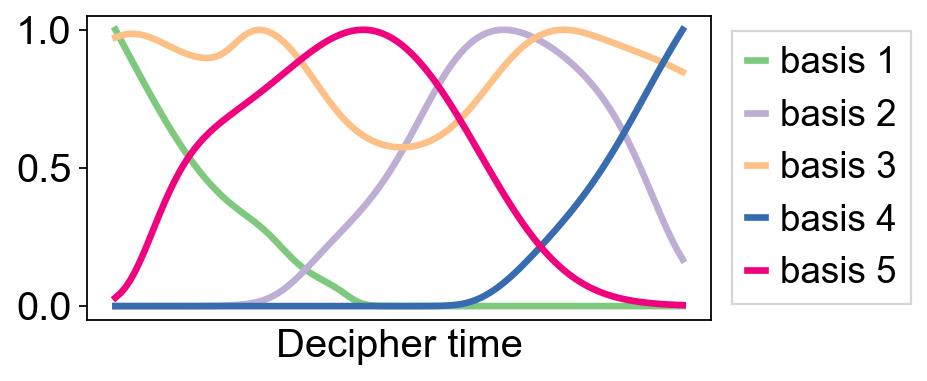

In [98]:
with plt.rc_context({"figure.figsize": [5,2.5]}):
    colors = sns.color_palette("Accent")
    colors = [colors[i] for i in [0, 1, 2, 4, 5]]
    plot_basis(basis, colors);
    plt.legend(loc="right", bbox_to_anchor=(1.35,0.5), fancybox=False)
plt.xticks([])
plt.xlabel("Decipher time")
plt.savefig(f"figures/figure3/AML1.basis.pdf",  bbox_inches="tight")

with strong uniform regularization
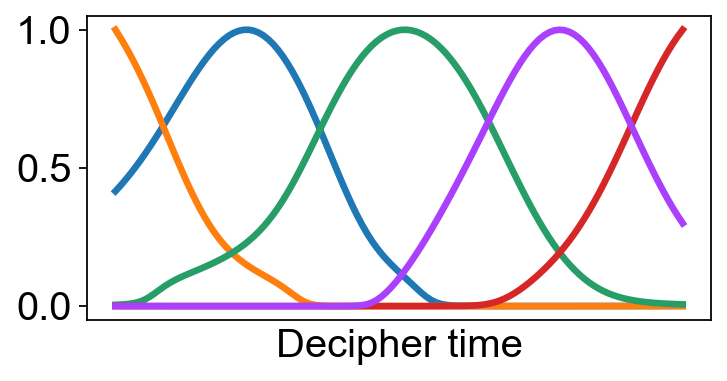

In [25]:
stable_genes = [
    "EEF2",
    "LYZ",
    "CD37",
    "BTF3",
    "EIF3F",
]
disrupted_genes = [
#     "A1BG",
    "HOXA9",
    "MEIS1",
    "CXCL3",
    "TRH",
    "HHEX",
]
studied_genes = stable_genes + disrupted_genes

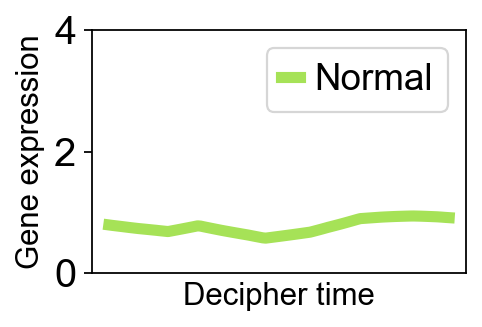

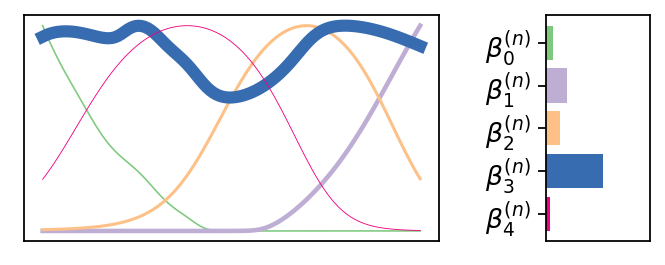

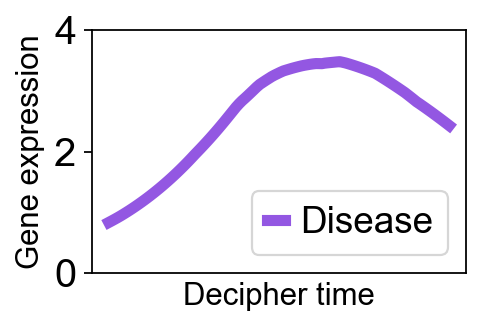

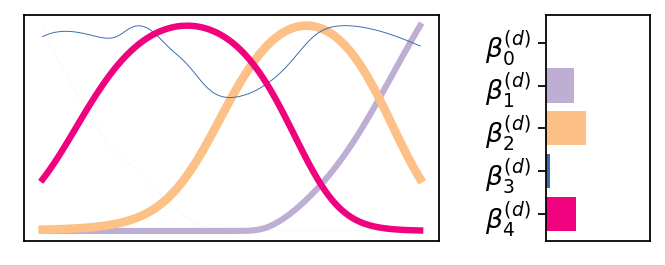

In [45]:
gene_name = "HOXA9"
g_id = adata.var_names.tolist().index(gene_name)
c = 1
for c in range(2):
    plt.figure(figsize=(3, 2))
    plt.plot(
        gene_patterns[c, g_id],
        label=["Normal", "Disease"][c],
        color=["#A6E257", "#9357E2"][c],
        linewidth=5,
    )
    plt.xticks([])
    plt.xlabel("Decipher time", fontsize=14)
    plt.ylabel("Gene expression", fontsize=14)
    plt.legend()
    plt.ylim(0, 4)
#     plt.savefig(
#         f"figures/figure1/AML1.gene_pattern.{['normal', 'disease'][c]}.{gene_name}.pdf",
#         bbox_inches="tight",
#     )

    fig, axes = plt.subplots(
        1, 2, gridspec_kw={"width_ratios": [4, 1]}, figsize=[4.5, 2]
    )
    colors = sns.color_palette("Accent")
    colors = [colors[i] for i in [0, 1, 2, 4, 5]]
    ax = axes[0]
    for i in range(5):
        ax.plot(
            basis[:, i],
            c=colors[i],
            label="$b_%d$" % i,
            linewidth=betas[c, g_id, i] * 10,
        )

    #     ax.axis(False)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[1]
    ax.barh(y=range(5)[::-1], width=betas[c, g_id], color=colors)

    ax.set_yticks(range(5)[::-1])
    ax.set_xlim(0, 1)
    ax.set_yticklabels(
        [f"$\\beta^{{({'nd'[c]})}}_%d$" % i for i in range(5)], fontsize=12
    )
    #     for k in ax.spines:
    #         ax.spines[k].set_visible(False)
    #     ax.xaxis.set_visible(False)
    ax.set_xticks([])
    fig.tight_layout()
#     plt.savefig(
#         f"figures/figure1/AML1.basis_decomposition.{['normal', 'disease'][c]}.{gene_name}.pdf",
#         bbox_inches="tight",
#     )

In [28]:
gene_scales

array([[1.4103919 , 1.4055654 , 1.1263121 , ..., 2.258122  , 3.0163476 ,
        0.41811994],
       [2.8142927 , 4.581277  , 6.517326  , ..., 0.5379299 , 7.544993  ,
        2.3629854 ]], dtype=float32)

Text(0, 0.5, 'Disruption score\nhealthy vs blast')

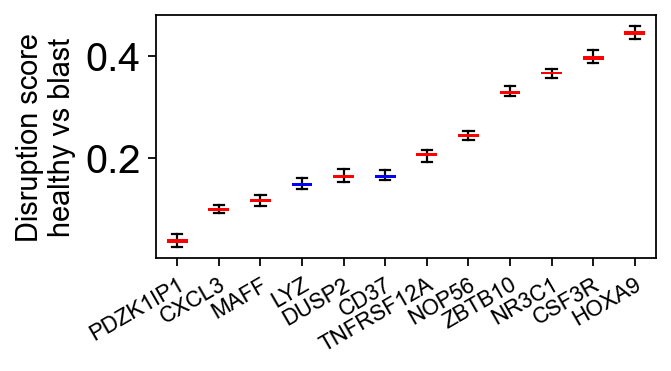

In [52]:
gene_names = np.array(adata.var_names).tolist() 

betas_samples = samples["beta"]["values"].squeeze()
betas_samples = betas_samples #* gene_scales[:,:,None]


plt.figure(figsize=(4,2))
distances = dict()
for i, g in enumerate(studied_genes):
    g_id = gene_names.index(g)
    
    dists = scipy.spatial.distance.cdist(
        betas_samples[:, 0, g_id].detach(),
        betas_samples[:, 1, g_id].detach(),
        metric="euclidean",
    )
    distances[g] = dists.flatten()
distances = pd.DataFrame(distances)

distances = distances[distances.mean().sort_values().index]

colors = ["blue" if g in stable_genes else "red" for g in distances.columns]
bplot = plt.boxplot(
    distances,
    patch_artist=True,
    labels=distances.columns,
    whis=(0, 100),
    boxprops={"lw": 0},
    medianprops={'lw': 0}
)
for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=30,ha='right', rotation_mode='anchor', fontsize=10)
plt.ylabel("Disruption score\nhealthy vs blast", fontsize=13)
# plt.xlabel("Gene")
# plt.savefig("figures/figure3/AML1.disruption.pdf", bbox_inches="tight")

In [48]:
gene_scales_df = pd.DataFrame(gene_scales.T, columns=["normal", "perturbed"],index=gene_names)
gene_scales_df["diff"] = gene_scales_df["perturbed"] - gene_scales_df["normal"]
gene_scales_df["diff-abs"] = gene_scales_df["diff"].abs()
# gene_scales_df["log_ratio"] = np.log(gene_scales_df["perturbed"]) - np.log(gene_scales_df["normal"])
# gene_scales_df["log_ratio-abs"] = gene_scales_df["log_ratio"].abs()

for k in ["diff-abs", ]: # "log_ratio-abs"
    gene_scales_df = gene_scales_df.sort_values(k, ascending=False)
    gene_scales_df[k+"-rank"] = np.arange(len(gene_scales_df))


In [49]:
len(gene_names)

3130

In [463]:
print(gene_scales_df.T[["HMGA1", "FOS", "KLF6", "JUNB", "JUND"]].to_markdown())

|               |    HMGA1 |     FOS |    KLF6 |     JUNB |    JUND |
|:--------------|---------:|--------:|--------:|---------:|--------:|
| normal        |  36.7372 | 56.7427 | 14.177  |  6.18307 | 11.0124 |
| perturbed     |  18.6229 | 96.3717 | 41.9008 | 36.1714  | 42.4856 |
| diff          | -18.1143 | 39.629  | 27.7238 | 29.9883  | 31.4732 |
| diff-abs      |  18.1143 | 39.629  | 27.7238 | 29.9883  | 31.4732 |
| diff-abs-rank | 112      | 43      | 72      | 62       | 59      |


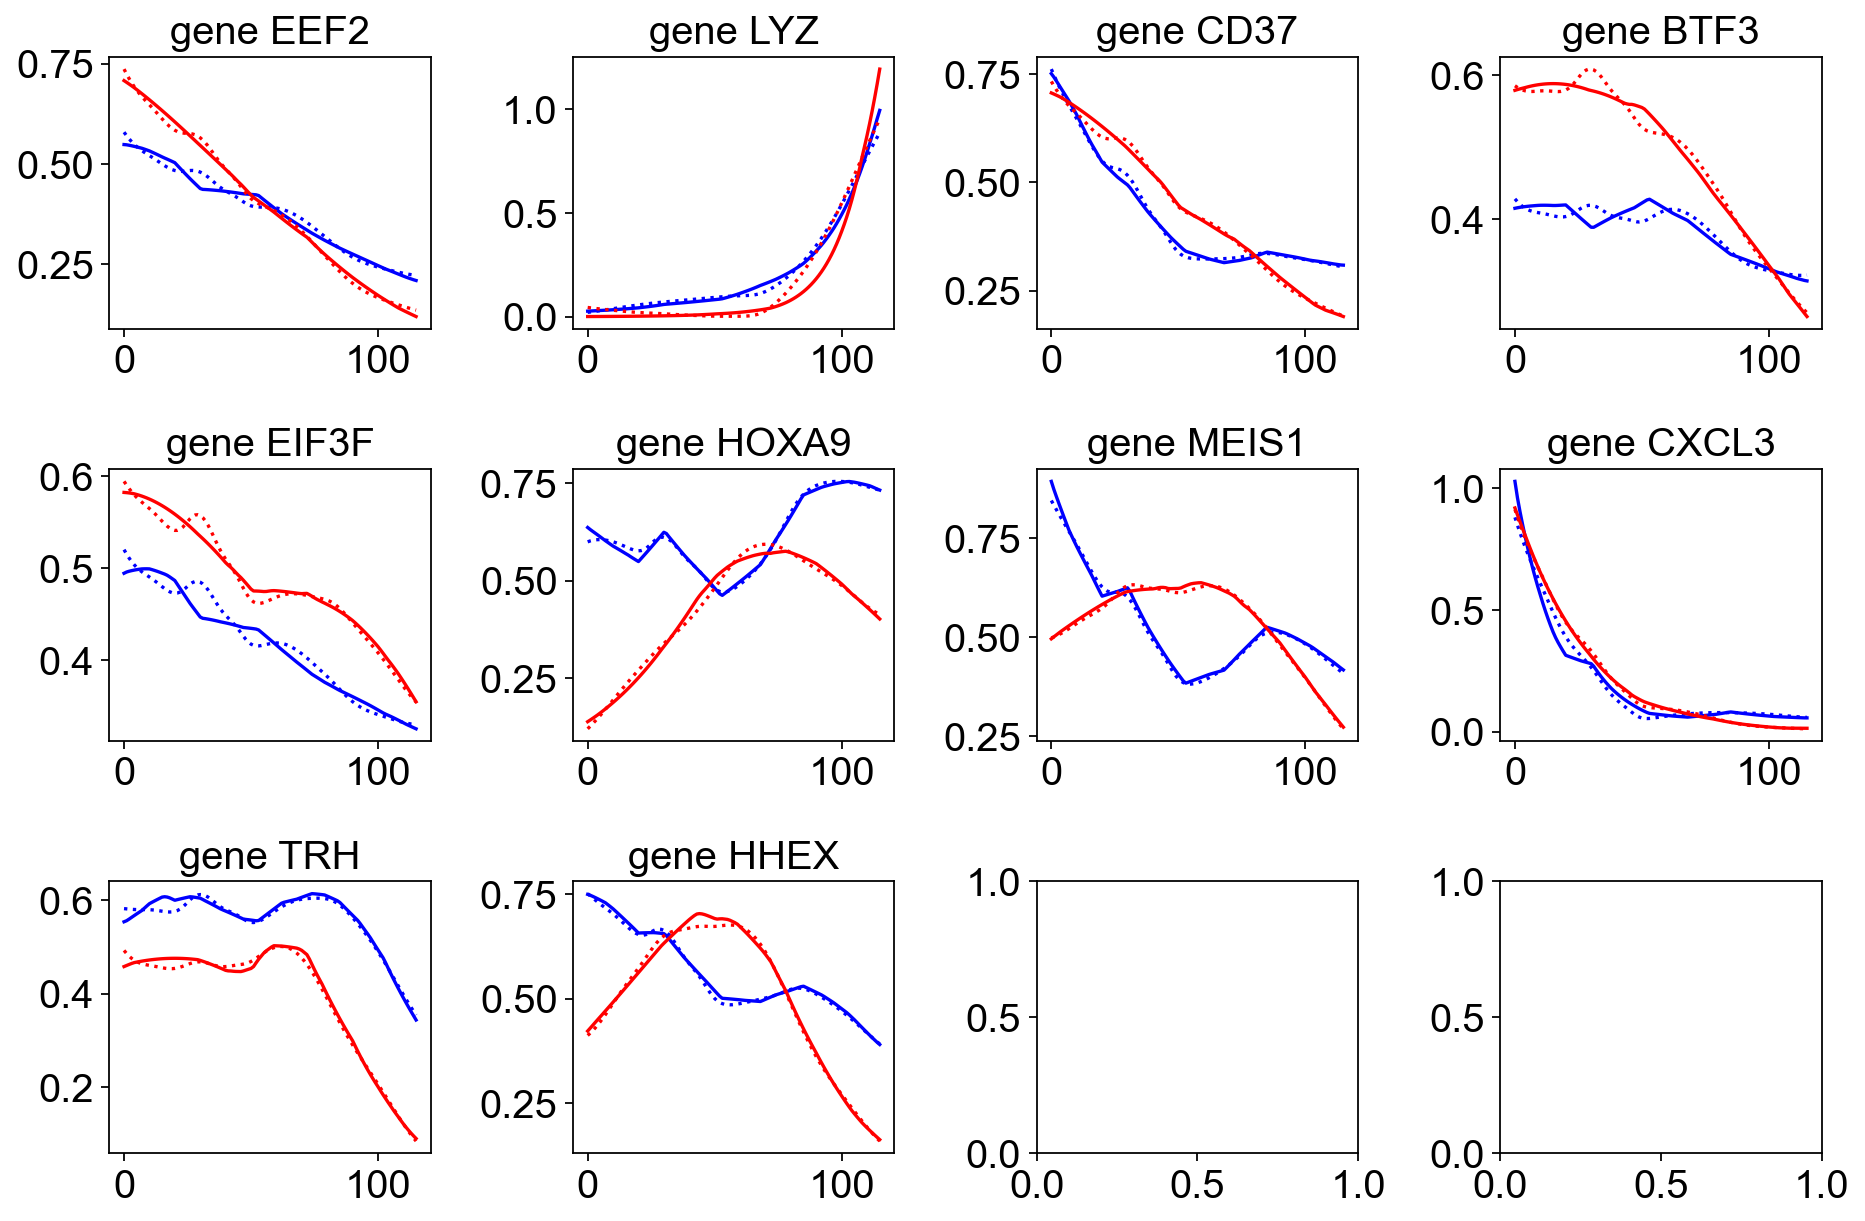

In [52]:
fig, axs = plt.subplots(3,4, figsize=(12,8))
for i, gene_name in enumerate(studied_genes):
    ax = axs.ravel()[i]
    GENE = adata.var_names.tolist().index(gene_name)
    ax.plot(gene_patterns[0, GENE,:]/ gene_scales[0,GENE], label="true pattern", c="b")
    ax.plot(samples["_RETURN"]["mean"].detach()[0, GENE,:] / gene_scales[0,GENE], label="reconstruction", ls=":", c="b")
    
    ax.plot(gene_patterns[1, GENE,:]/ gene_scales[1,GENE], label="true pattern", c="r")
    ax.plot(samples["_RETURN"]["mean"].detach()[1, GENE,:]/ gene_scales[1,GENE], label="reconstruction", ls=":", c="r")
    ax.set_title(f"gene {gene_name}")
plt.tight_layout()
plt.show()

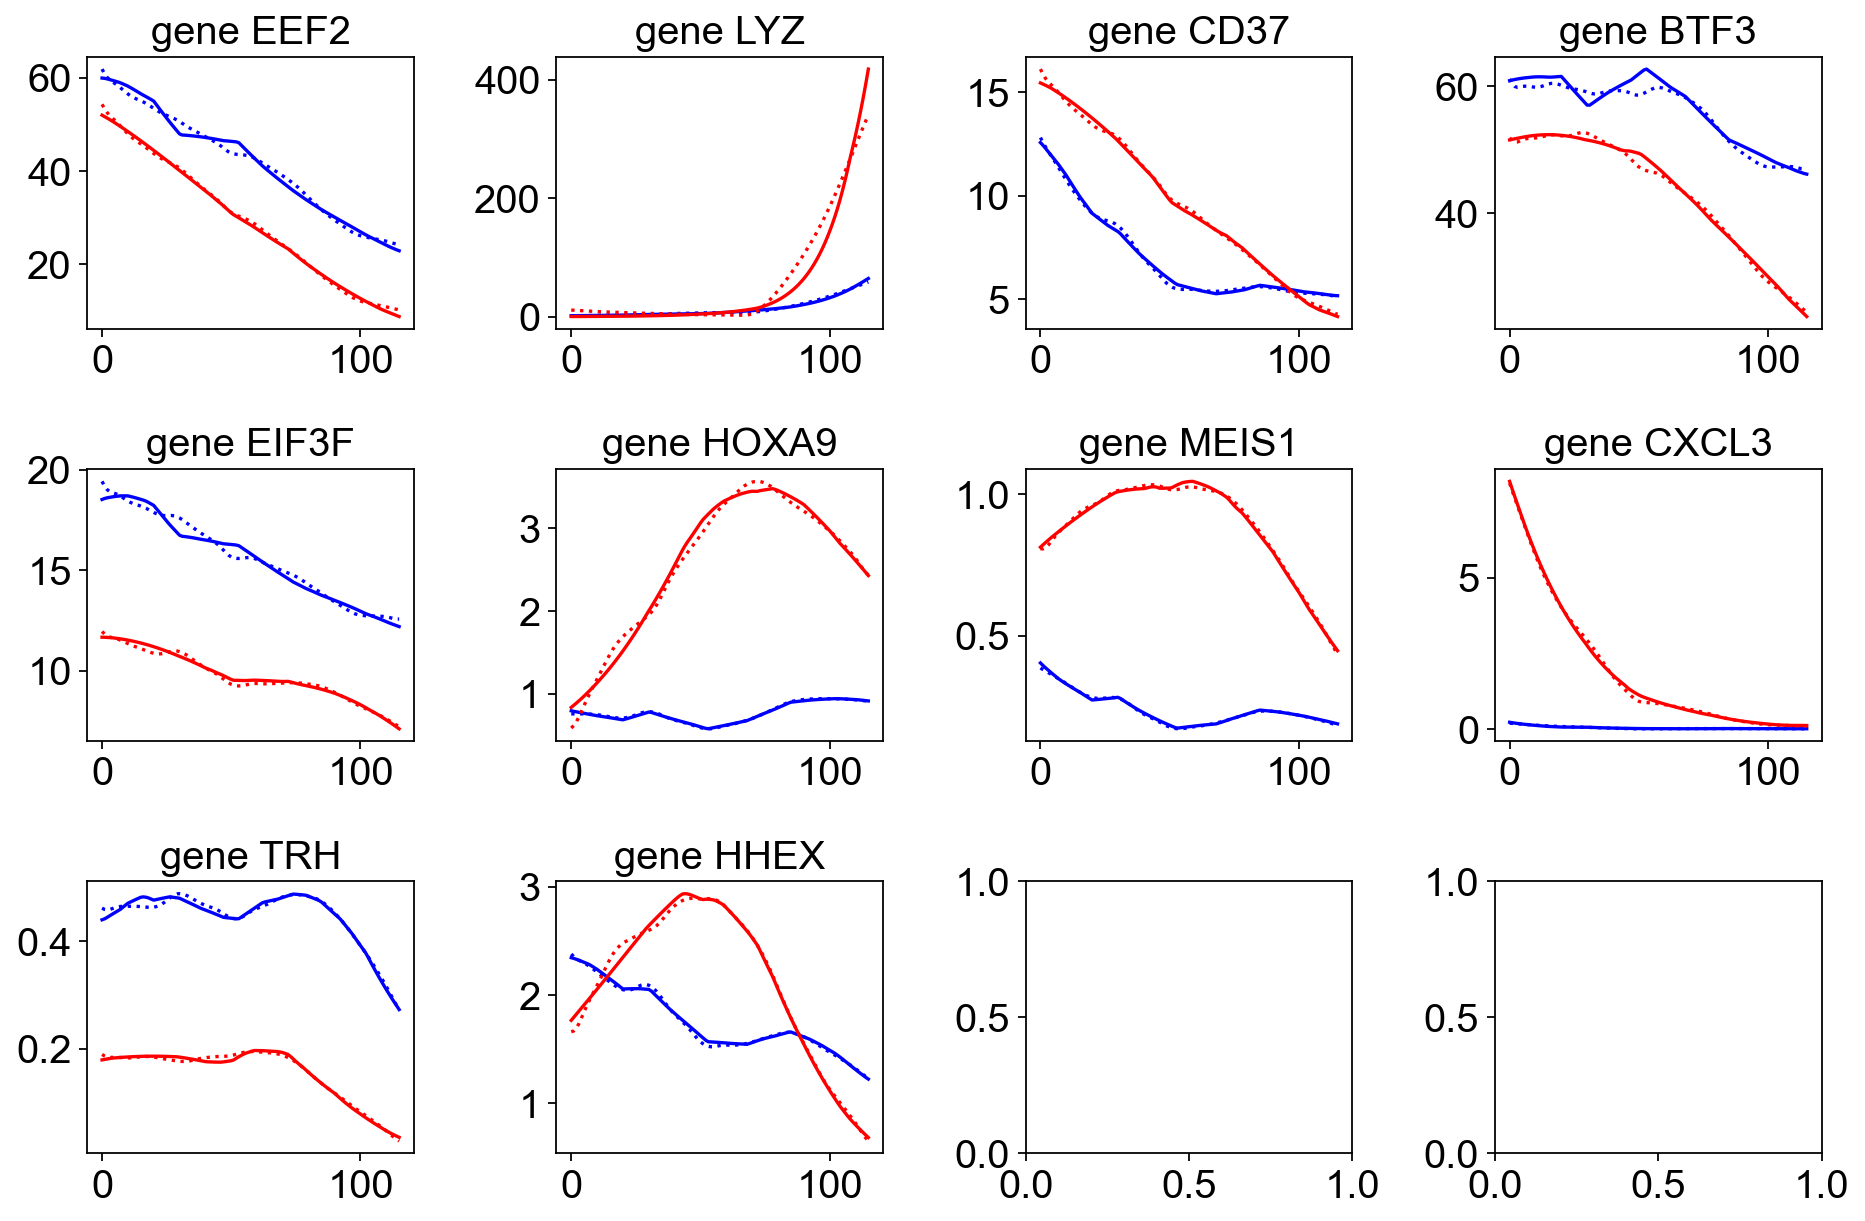

In [315]:
fig, axs = plt.subplots(3,4, figsize=(12,8))
for i, gene_name in enumerate(studied_genes):
    ax = axs.ravel()[i]
    GENE = adata.var_names.tolist().index(gene_name)
    ax.plot(gene_patterns[0, GENE,:], label="true pattern", c="b")
    ax.plot(samples["_RETURN"]["mean"].detach()[0, GENE,:] , label="reconstruction", ls=":", c="b")
    
    ax.plot(gene_patterns[1, GENE,:], label="true pattern", c="r")
    ax.plot(samples["_RETURN"]["mean"].detach()[1, GENE,:], label="reconstruction", ls=":", c="r")
    ax.set_title(f"gene {gene_name}")
plt.tight_layout()
plt.show()

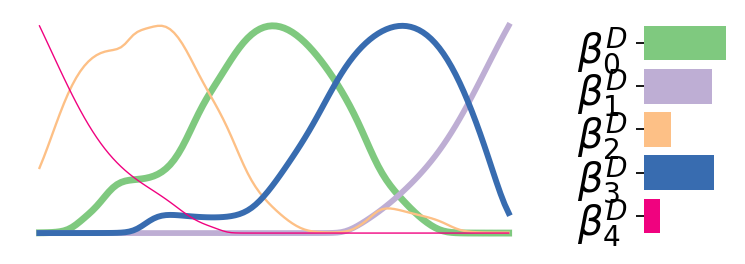
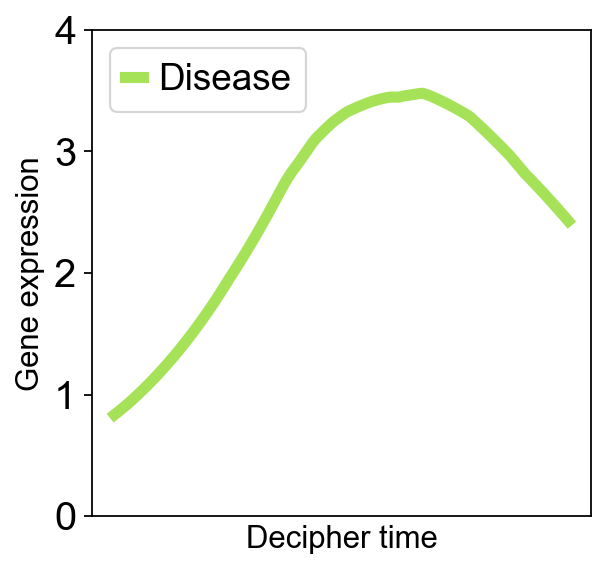

In [12]:
from pyro.infer import Predictive

In [252]:
def impute_data(self, x):
    z_loc, _ = self.guide(x)
    mu = self.decoder_z_to_x(z_loc)
    mu = torch.softmax(mu, dim=-1)
    library_size = x.sum(axis=-1, keepdim=True)
    return library_size * mu



array([2.25289797e-02, 1.88399221e-01, 5.24312139e-01, 1.23517962e+00,
       4.02204142e+00, 2.89490073e+01])

In [256]:
# adata.varm['trajectory_basis_healthy'] = samples["beta"]["mean"].squeeze().numpy()[0]
# adata.varm['trajectory_basis_disease'] = samples["beta"]["mean"].squeeze().numpy()[1]




# disruption_scores = np.diag(
#     scipy.spatial.distance.cdist(
#         samples["beta"]["values"].squeeze().mean(0)[0],
#         samples["beta"]["values"].squeeze().mean(0)[1],
#     )
# )
# adata.var["disruption_score"] = disruption_scores

adata.obsm["imputed_expression"] = impute_data(model, torch.tensor(adata.X.toarray())).detach().numpy()

sc.write("analysis/AML1.decipher.post-analyzed.h5ad", adata)



Only considering the two last: ['.post-analyzed', '.h5ad'].
Only considering the two last: ['.post-analyzed', '.h5ad'].


In [349]:
n_samples = 100
normal_gene_patterns_samples = sample_from_decipher_trajectory(
    adata, model, normal_trajectory.trajectory_latent, n_samples=n_samples, smooth=0
)
perturbed_gene_patterns_samples = sample_from_decipher_trajectory(
    adata, model, perturbed_trajectory.trajectory_latent, n_samples=n_samples, smooth=0
)



In [60]:
def plot_gene_patterns_normal_perturbed(gene_name, crop_to_equal_length=False):
    plot_gene_patterns(
        gene_name,
        adata,
        [normal_trajectory, perturbed_trajectory],
        [normal_gene_patterns_samples, perturbed_gene_patterns_samples],
        [palette_original["Healthy"], palette_original["AML1"]],
        ["Normal", "Perturbed"],
        crop_to_equal_length,
    )
    add_cell_type_band(perturbed_trajectory, palette_original)

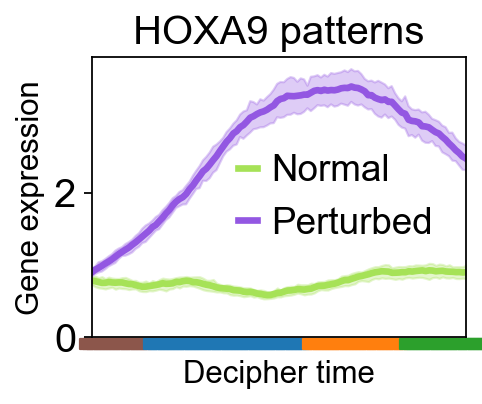

In [375]:
plot_gene_patterns_normal_perturbed(
    "HOXA9",
    crop_to_equal_length=True,
)
plt.savefig("figures/figure1/AML1.gene_pattern.HOXA9.pdf", bbox_inches="tight")


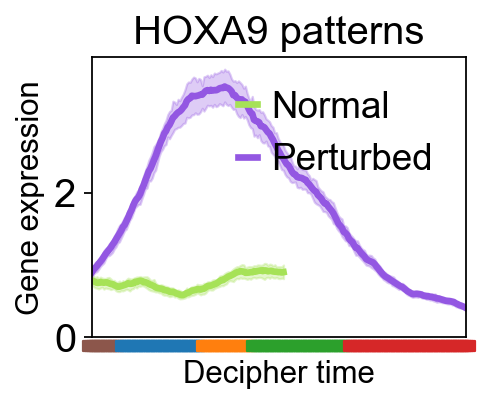

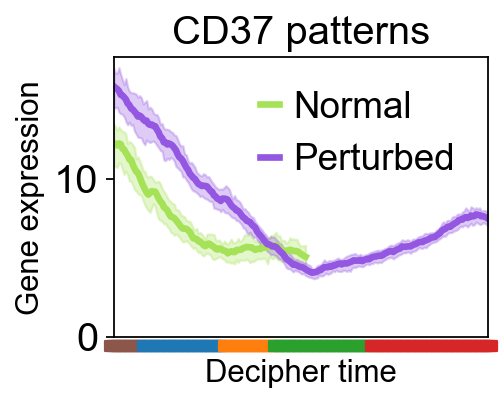

In [383]:
for g in ["HOXA9", "CD37"]:
    plot_gene_patterns_normal_perturbed(
        g,
        crop_to_equal_length=False,
    )
    
    plt.savefig(f"figures/figure3/AML1.gene_patterns.{g}.pdf", bbox_inches="tight")

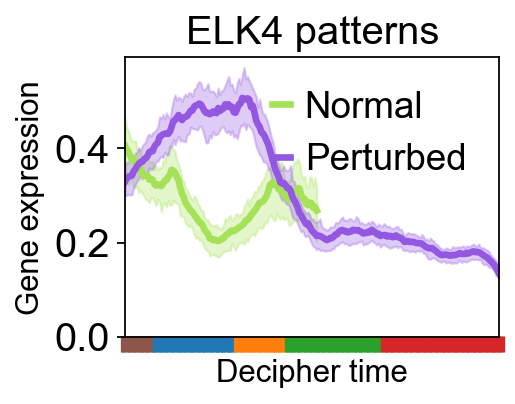

In [163]:
plot_gene_patterns_normal_perturbed(
    "ELK4",
    crop_to_equal_length=False,
)


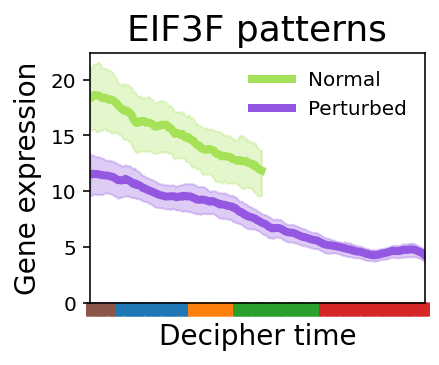

In [140]:
plot_gene_patterns_normal_perturbed("EIF3F")

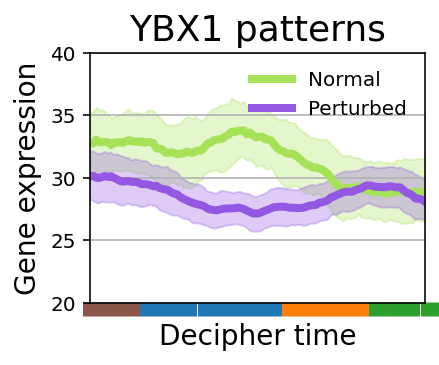

In [206]:
plot_gene_patterns_normal_perturbed("YBX1", crop_to_equal_length=True)
plt.ylim(20,40)
plt.grid()

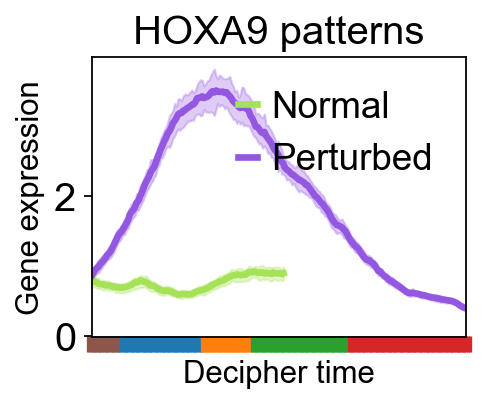

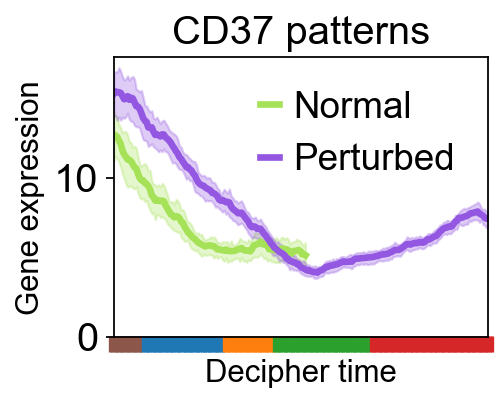

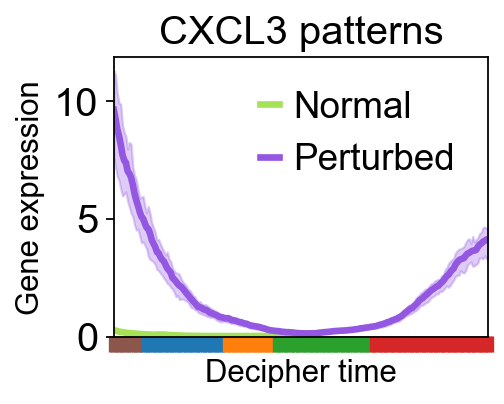

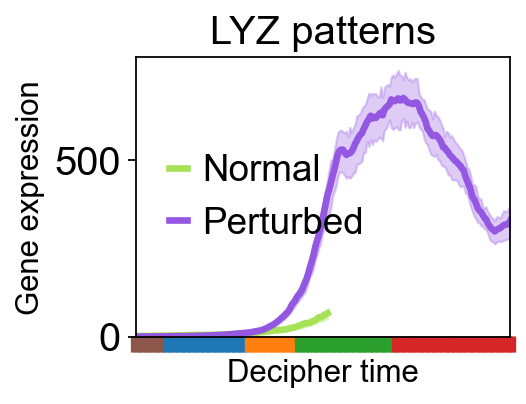

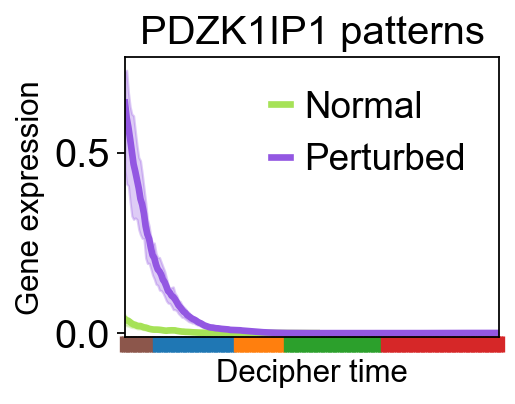

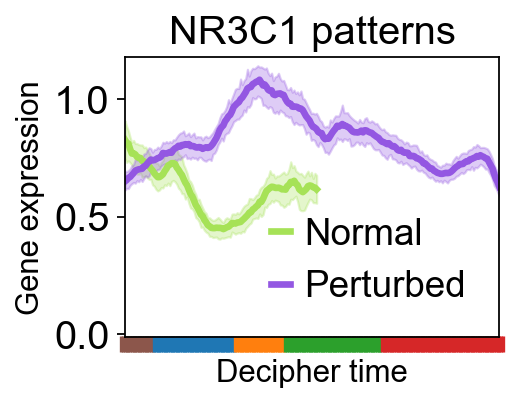

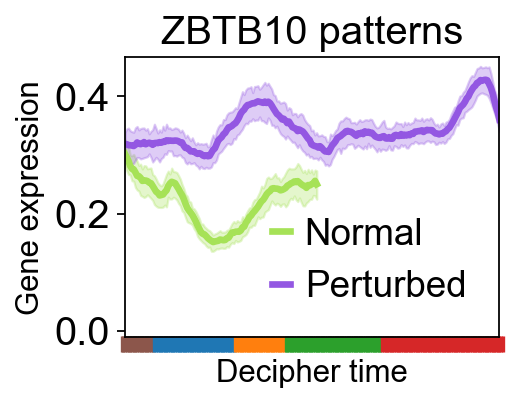

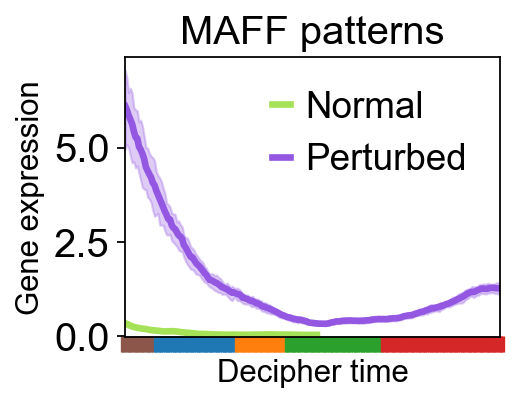

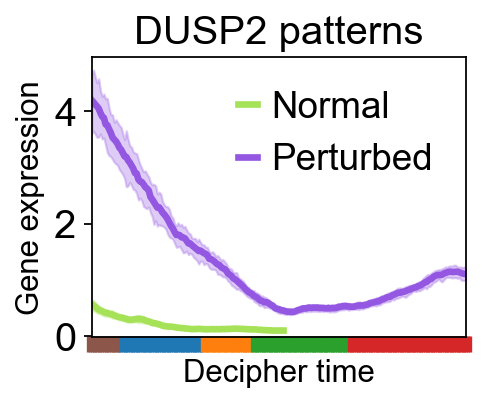

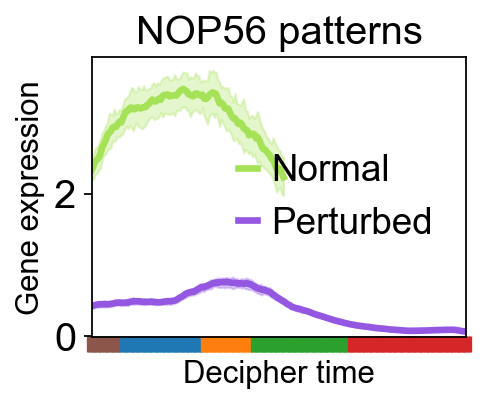

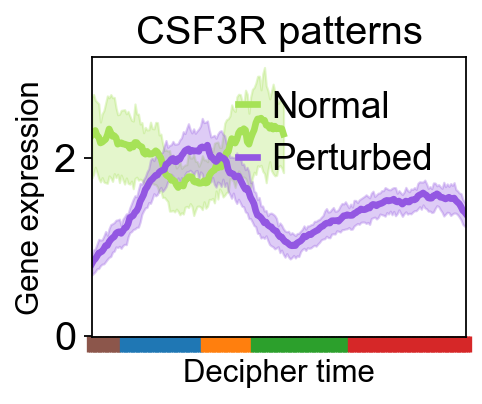

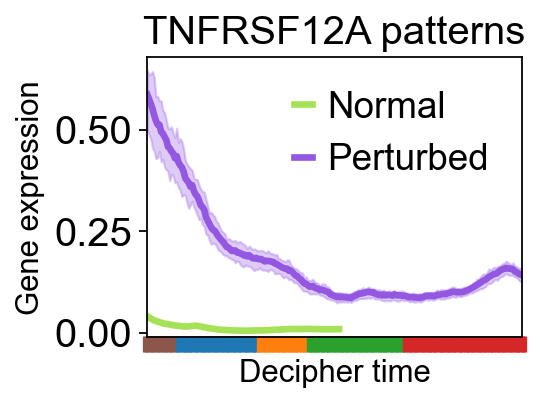

In [166]:
for g in [
    "HOXA9",
    "CD37",
    "CXCL3",
    "LYZ",
    "PDZK1IP1",
    "NR3C1",
    "ZBTB10",
    "MAFF",
    "DUSP2",
    "NOP56",
    "CSF3R",
    "TNFRSF12A",
]:
    plot_gene_patterns_normal_perturbed(g)
    plt.ylim(-0.01)
    plt.savefig(f"figures/figure3/AML1.gene_patterns.{g}.pdf", bbox_inches="tight")

In [69]:
n_samples = 100
normal_gene_patterns_samples = gene_patterns_from_decipher_trajectory(
    adata, model, "origin=Healthy", n_samples=n_samples, return_mean=False,
)
perturbed_gene_patterns_samples = gene_patterns_from_decipher_trajectory(
    adata, model, "origin=AML1", n_samples=n_samples, return_mean=False,
)

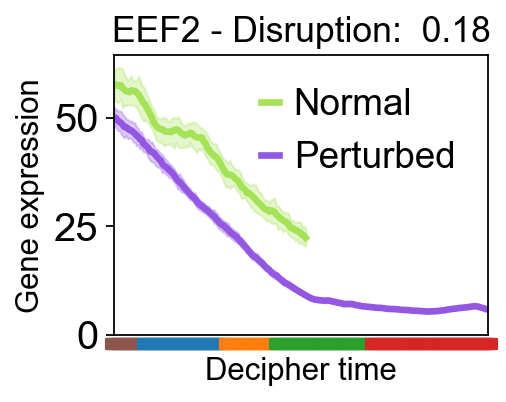

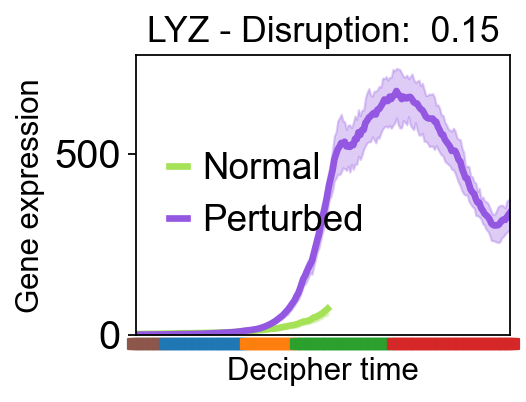

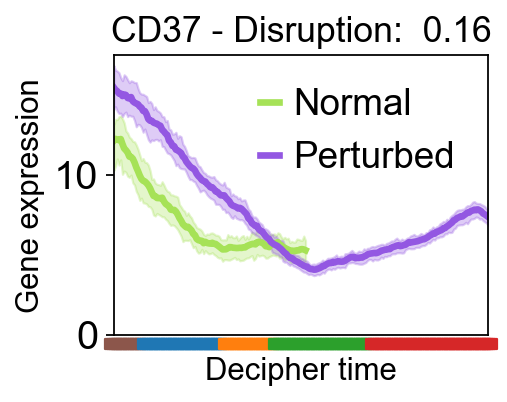

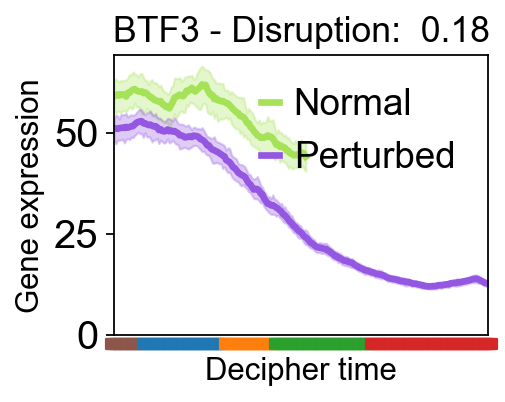

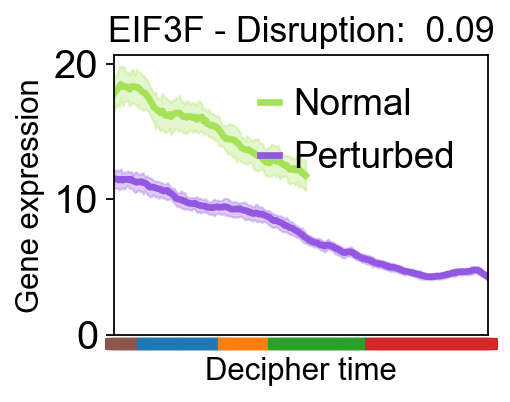

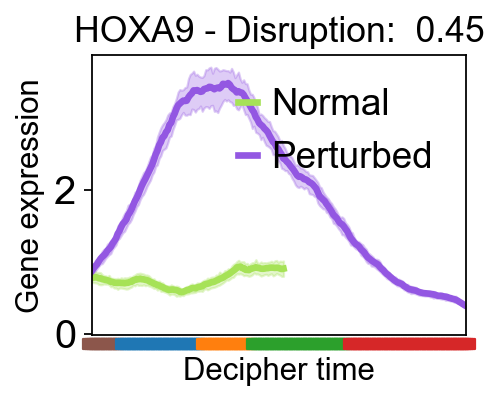

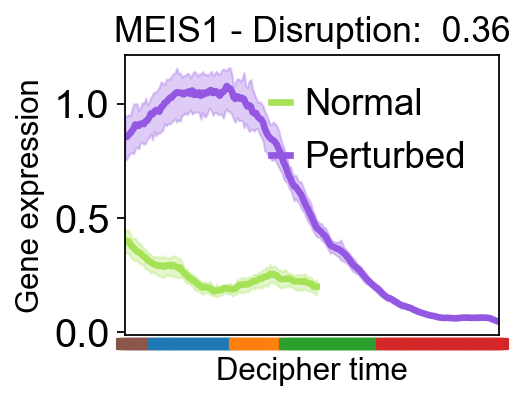

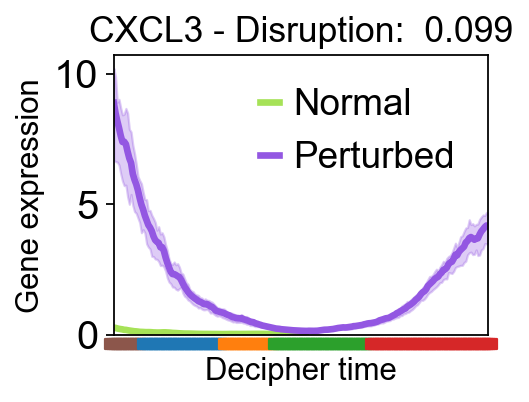

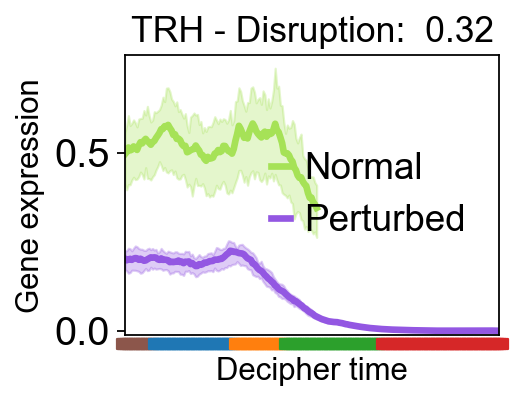

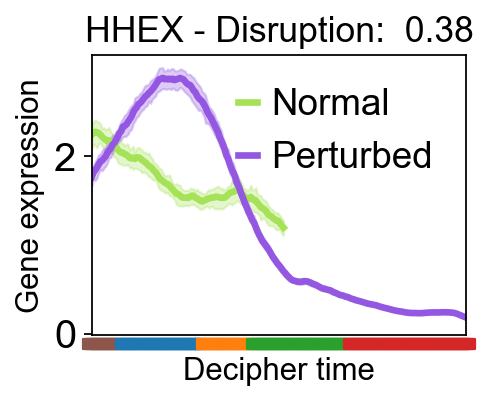

In [80]:
for g in studied_genes:
    g_id = gene_names.index(g)
    beta_g = adata.uns["decipher_basis_decomposition"]["betas"][:, g_id, :]
    disruption = np.linalg.norm(beta_g[0] - beta_g[1], ord=2)
    plot_gene_patterns_normal_perturbed(g)
    plt.title(f"{g} - Disruption:  {disruption:.2}", fontsize=16)
    plt.ylim(-0.01)
    plt.savefig(f"figures/figure3/AML1.gene_patterns.{g}.pdf", bbox_inches="tight")

import pickle

with open("analysis/AML1.trajectory.normal.pkl", "wb") as f:
    pickle.dump(normal_trajectory, f)

with open("analysis/AML1.trajectory.perturbed.pkl", "wb") as f:
    pickle.dump(perturbed_trajectory, f)

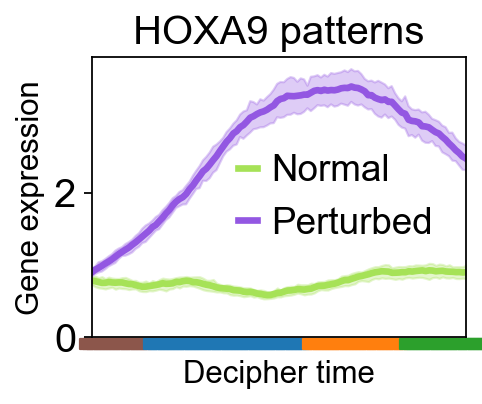

In [368]:
plot_gene_patterns_normal_perturbed(
    "HOXA9",
    crop_to_equal_length=True,
)
